In [1]:
%matplotlib inline
import nengo
import numpy as np
import pylab

## Using Nengo to define a model to be run with a different simulator

This is meant as an example script to take a standard Nengo model and extract out the information needed to simulate it outside of Nengo.  When developing a new backend, we often use this as a first step to figure out the process that would need to be automated.

### Step 1: Define the model

In [2]:
model = nengo.Network()
with model:
    def stim_a_func(t):
        return np.sin(t*2*np.pi)
    stim_a = nengo.Node(stim_a_func)
    a = nengo.Ensemble(n_neurons=50, dimensions=1)
    nengo.Connection(stim_a, a)
    
    def stim_b_func(t):
        return np.cos(t*np.pi)
    stim_b = nengo.Node(stim_b_func)
    b = nengo.Ensemble(n_neurons=50, dimensions=1)
    nengo.Connection(stim_b, b)
    
    c = nengo.Ensemble(n_neurons=200, dimensions=2, radius=1.5)
    nengo.Connection(a, c[0])
    nengo.Connection(b, c[1])
    
    d = nengo.Ensemble(n_neurons=50, dimensions=1)
    
    def multiply(x):
        return x[0] * x[1]
    nengo.Connection(c, d, function=multiply)

    data = []
    def output_function(t, x):
        data.append(x)
    output = nengo.Node(output_function, size_in=1)
    nengo.Connection(d, output, synapse=0.03)
    


### Step 2: Run it in normal Nengo

Simulation finished in 0:00:02.                                                 


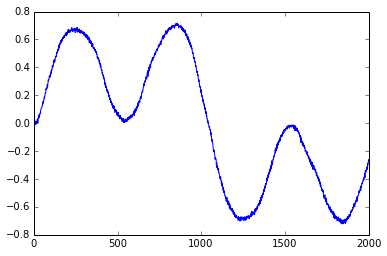

In [3]:
sim = nengo.Simulator(model)
sim.run(2)

pylab.plot(data)

### Step 3: Extract data about groups of neurons

In [4]:
for ens in model.all_ensembles:
    print('Ensemble %d' % id(ens))
    print('    number of neurons: %d' % ens.n_neurons)
    print('    tau_rc: %g' % ens.neuron_type.tau_rc)
    print('    tau_ref: %g' % ens.neuron_type.tau_ref)
    print('    bias: %s' % sim.data[ens].bias)

Ensemble 54978880
    number of neurons: 50
    tau_rc: 0.02
    tau_ref: 0.002
    bias: [  5.36301911e-01   6.35003357e+00  -1.68604461e+02   1.84899177e+00
   3.30085928e+00  -1.80561722e+01   1.04969542e+01  -4.00247132e+00
   1.93608842e+00  -1.65907986e+02  -1.90784389e+00   3.07432809e+00
   5.99176287e+00   6.51427013e+00   1.53497626e-01   1.50899425e+00
  -4.55871462e+00  -2.98739162e+01   3.61266298e+00   8.21982406e-01
  -1.77936838e+02  -3.63134719e+00   1.06216064e+01   2.38301439e+00
  -3.15011763e+01   5.90426199e+00   6.21281935e+00  -2.73467062e+01
   7.11055550e+00  -8.79765786e+01  -1.61631915e+01   4.70228795e+00
   6.59597395e+00   1.60831884e+00   1.06933341e+01   9.54774709e+00
   7.99108390e+00  -3.39117756e+02  -2.67361662e+01  -1.32731163e+02
  -8.55889037e-01  -7.49063115e+00   1.31636585e+00   1.02467507e+01
  -9.77894544e+01   2.74869475e+00   3.98249124e+00  -2.10870693e+01
   5.23838511e+00  -5.31936919e+00]
Ensemble 31828792
    number of neurons: 50
  

### Step 4: Extract data about inputs

In [5]:
for node in model.all_nodes:
    if node.size_out > 0:
        print('Input node %d' % id(node))
        print('Function to call: %s' % node.output)

Input node 169474592
Function to call: <function stim_a_func at 0x000000000A1959E8>
Input node 7571104
Function to call: <function stim_b_func at 0x0000000001E5EB38>


### Step 5: Extract data about outputs

In [6]:
for node in model.all_nodes:
    if node.size_in > 0:
        print('Output node %d' % id(node))
        print('Function to call: %s' % node.output)

Output node 169475768
Function to call: <function output_function at 0x000000000A195A58>


### Step 6: Extract data about connections between Ensembles

In [7]:
for conn in model.all_connections:
    if isinstance(conn.pre_obj, nengo.Ensemble) and isinstance(conn.post_obj, nengo.Ensemble):
        print('Connection from %d to %d' % (id(conn.pre_obj), id(conn.post_obj)))
        print('    synapse time constant: %g' % conn.synapse.tau)        
        decoder = sim.data[conn].weights
        transform = nengo.utils.builder.full_transform(conn, allow_scalars=False)
        encoder = sim.data[conn.post_obj].scaled_encoders
        print('    decoder: %s' % decoder)
        print('    transform: %s' % transform)
        print('    encoder: %s' % encoder)


Connection from 54978880 to 169475264
    synapse time constant: 0.005
    decoder: [[ -7.19633169e-05  -1.78741484e-04   6.46361094e-05  -1.11256403e-04
    1.25990977e-04   6.38863978e-05  -2.38751459e-04  -7.56944887e-05
   -1.12044869e-04   4.57887721e-05  -8.17143547e-05  -1.73650322e-04
    1.40837307e-04   1.54240417e-04  -6.85479733e-05  -1.09674639e-04
   -8.42420730e-05  -8.26932022e-05  -1.89643076e-04   2.27746610e-04
   -8.10363725e-05  -9.56682150e-05   1.56767723e-04   1.23767807e-04
    2.36667204e-04   1.39588685e-04  -2.95998600e-04   1.47338317e-04
    1.31934555e-04   5.15740715e-05  -1.50849715e-04  -2.22926053e-04
    1.46679431e-04  -1.06175055e-04  -2.52538558e-04   1.56603662e-04
    1.50514883e-04   4.23109252e-05   1.19678905e-04   2.16870152e-05
    2.13604262e-04   8.79059283e-05   1.73624241e-04   1.73048316e-04
   -1.65876119e-04   1.14896819e-04  -2.26929527e-04   6.12553267e-05
    1.35056933e-04  -1.05793233e-04]]
    transform: [[ 1.]
 [ 0.]]
    enco

### Step 7: Extract data about inputs

In [8]:
for conn in model.all_connections:
    if isinstance(conn.pre_obj, nengo.Node) and isinstance(conn.post_obj, nengo.Ensemble):
        print('Connection from input %d to %d' % (id(conn.pre_obj), id(conn.post_obj)))
        print('    synapse time constant: %g' % conn.synapse.tau)        
        transform = nengo.utils.builder.full_transform(conn, allow_scalars=False)
        encoder = sim.data[conn.post_obj].scaled_encoders
        print('    transform: %s' % transform)
        print('    encoder: %s' % encoder)


Connection from input 169474592 to 54978880
    synapse time constant: 0.005
    transform: [[ 1.]]
    encoder: [[  -9.76827208]
 [  -6.02814891]
 [ 197.83912915]
 [ -10.14439215]
 [   6.52682433]
 [  26.05899661]
 [ -11.26967343]
 [ -30.07881565]
 [  -6.37904379]
 [ 187.64486175]
 [ -34.26702021]
 [  -9.09819384]
 [   7.86515966]
 [  15.34816994]
 [ -10.57105725]
 [ -17.06405338]
 [ -25.72071465]
 [ -38.2402476 ]
 [  -5.26423124]
 [   9.44622906]
 [-196.27778354]
 [ -11.87655947]
 [  16.04232069]
 [   5.46286115]
 [  69.8177485 ]
 [   7.79895678]
 [ -16.67994583]
 [  53.12247335]
 [   6.38714938]
 [ 104.06781792]
 [ -32.93703656]
 [  -7.02124523]
 [   7.21535806]
 [ -12.69695178]
 [ -12.21956146]
 [   9.51982899]
 [   8.07007305]
 [ 364.45594139]
 [  46.00438214]
 [ 140.79373454]
 [   9.04913851]
 [  16.11824636]
 [   6.46717367]
 [  12.34391846]
 [-128.99708974]
 [   5.28396728]
 [  -8.3766421 ]
 [  29.294484  ]
 [   6.3648384 ]
 [ -14.35856558]]
Connection from input 7571104 to 318

### Step 8: Extract data about outputs:

In [9]:
for conn in model.all_connections:
    if isinstance(conn.pre_obj, nengo.Ensemble) and isinstance(conn.post_obj, nengo.Node):
        print('Connection from %d to output %d' % (id(conn.pre_obj), id(conn.post_obj)))
        print('    synapse time constant: %g' % conn.synapse.tau)
        decoder = sim.data[conn].weights
        transform = nengo.utils.builder.full_transform(conn, allow_scalars=False)
        print('    decoder: %s' % decoder)
        print('    transform: %s' % transform)


Connection from 169475600 to output 169475768
    synapse time constant: 0.03
    decoder: [[ -1.48053450e-04   1.28126240e-04  -2.73442492e-04   8.99790713e-05
    1.19622892e-04   8.77994864e-05   1.04686027e-04   1.40789285e-04
    1.18880505e-04  -1.78032888e-04   1.38440083e-04   9.19944786e-05
    4.91674560e-05  -1.07879808e-05  -1.55722499e-04  -2.01868835e-04
   -1.11416040e-04  -1.47526334e-04  -1.03399397e-04   1.03226100e-04
    1.16099957e-04   1.15469191e-04   1.01985062e-04   9.05788035e-05
   -1.15099098e-04  -1.19940757e-04   1.40683428e-04   1.05237173e-04
    8.80772107e-06  -1.10314066e-04   1.07537114e-04   9.66150194e-05
   -1.52785766e-04   9.13238226e-05  -1.39711902e-04   9.71650505e-05
    9.07523917e-05  -1.19987722e-04   1.05571490e-04  -1.43404268e-04
    2.12816037e-04  -3.16001159e-04   1.17057221e-04  -1.29543671e-04
    9.37569930e-05   1.21675271e-04   1.97056439e-04   9.28029690e-05
   -2.76812285e-04  -1.52502587e-04]]
    transform: [[ 1.]]


### Export the data to some simulator

In theory, the above information is all that is needed to run the model.  The neurons are all LIF neurons with the stated refractory period, membrane time constant, and background input.  They are scaled such that their reset voltage is 0 and their firing threshold is 1.0.

For connections, the code above gives a set of matrices.  The actual connection weight matrix is defined by multiplying those matrices together.  You can either implement them as a sequence of matrices (if your simulator supports this), or you can multiply them together to get a full weight matrix.  For example, for the Connections between ensembles, you would do ```np.dot(encoder, np.dot(transform, decoder))```.

For inputs to the system, the input Node generally has a function.  This function should be called, passing in the current time since the beginning of the simulation (in seconds) as ```t```.  The result is the value that should be fed into the inputs to the neurons (after multiplying by the transform and the encoder).

For outputs from the system, the activity of all the neurons is multiplied by the decoder and the transform, resulting in a value ```x```.  This value (and ```t```) is passed into the output node's function.  Note that a Node can act as both input and output.

Each Connection also has a synapse value.  This is an exponential filter that should be applied with the provided time constant.
